# <center> Merger Model Architecture </center>

In [87]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout,Flatten,add,Dot,GRU
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)

In [88]:
def plot_loss_acc(history):
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Loading Pickle Files

In [7]:
labels=pickle.load( open('labels.pkl', 'rb'))
features=pickle.load( open('features.pkl', 'rb'))
features_tfidf= pickle.load( open('features_tfidf.pkl', 'rb'))
word_tfidf_weights=pickle.load( open('word_tfidf_weights.pkl', 'rb'))
non_text_features_np = features.drop(columns=['title', 'text', 'combined_text', 'label']).to_numpy()

# Generating Seqeuences

In [9]:
train_texts = features["combined_text"]
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts)  # train_texts is a list of input texts
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_data = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=400)
vocab_size = len(tokenizer.word_index) + 1

## Input - 1 Sequences

In [11]:
train_ft,test_ft,train_labels,test_labels=train_test_split(train_data,labels,test_size=0.2, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", test_ft.shape)

Training set shape: (45783, 400)
Validation set shape: (11446, 400)
Test set shape: (14308, 400)


## Input - 1 Extracted Features

In [12]:
train_txt_ft,test_txt_ft,train_txt_labels,test_txt_labels=train_test_split(non_text_features_np,labels,test_size=0.2, train_size=0.8)
X_txt_train, X_txt_val, y_txt_train, y_txt_val = train_test_split(train_txt_ft, train_txt_labels, test_size=0.2, random_state=42)

print("Training set shape:", X_txt_train.shape)
print("Validation set shape:", X_txt_val.shape)
print("Test set shape:", test_txt_ft.shape)

Training set shape: (45783, 15)
Validation set shape: (11446, 15)
Test set shape: (14308, 15)


# Merger Model

In [58]:
class Merger_Model(Model):
    def __init__(self,vocab_size):
        super(Merger_Model,self).__init__()
        #self.input_1= Input(shape=(15,))
        self.input_1_dropout= Dropout(0.4)
        self.input_1_dense= Dense(32,activation="relu")
        
        #self.input_2=Input(shape=(400,))
        self.input_2_embed= Embedding(vocab_size,128)
        self.input_2_dropout= Dropout(0.3)
        self.input_2_GRU = GRU(32)
        
        self.merge_output= Dense(32, activation="relu")
        self.flatten= Flatten()
        self.output_1= Dense(1,activation="sigmoid")
        
    def call(self,inputs):
        #print(inputs)
        #print(inputs[0].shape,inputs[1].shape)
        #x1=self.input_1(inputs[0])
        x1=self.input_1_dropout(inputs[0])
        x1=self.input_1_dense(x1)
        
       # x2=self.input_2(inputs[1])
        x2=self.input_2_embed(inputs[1])
        x2=self.input_2_dropout(x2)
        x2=self.input_2_GRU(x2)
        
        x3=add([x1,x2])
        x3=self.merge_output(x3)
        x3=self.flatten(x3)
        x3=self.output_1(x3)
        
        return x3
         

In [59]:
merge=Merger_Model(vocab_size)

In [60]:
merge.build([(None,15),(None,400)])

In [61]:
merge.summary()

Model: "merger__model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_27 (Dropout)        multiple                  0         
                                                                 
 dense_38 (Dense)            multiple                  512       
                                                                 
 embedding_13 (Embedding)    multiple                  44658816  
                                                                 
 dropout_28 (Dropout)        multiple                  0         
                                                                 
 gru_13 (GRU)                multiple                  15552     
                                                                 
 dense_39 (Dense)            multiple                  1056      
                                                                 
 flatten_12 (Flatten)        multiple             

## Configuring Model

In [68]:
opt=keras.optimizers.Adam(learning_rate=0.001)
merge.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
early_stop= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
save_model=tf.keras.callbacks.ModelCheckpoint("merger_model", save_best_only=True)

## Training model

In [69]:
history=merge.fit(
    [X_txt_train,X_train],
    y_train, 
    epochs=10, 
    batch_size=264, 
    validation_data=([X_txt_val,X_val],y_val),
    callbacks=[save_model,early_stop])

Epoch 1/10
174/174 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.9663

INFO:tensorflow:Assets written to: merger_model\assets


INFO:tensorflow:Assets written to: merger_model\assets


174/174 [==============================] - 244s 1s/step - loss: 0.3276 - accuracy: 0.9663 - val_loss: 0.3721 - val_accuracy: 0.9366
Epoch 2/10
174/174 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9796

INFO:tensorflow:Assets written to: merger_model\assets


INFO:tensorflow:Assets written to: merger_model\assets


174/174 [==============================] - 264s 2s/step - loss: 0.1200 - accuracy: 0.9796 - val_loss: 0.3655 - val_accuracy: 0.9393
Epoch 3/10
174/174 [==============================] - 262s 2s/step - loss: 0.0806 - accuracy: 0.9862 - val_loss: 0.4037 - val_accuracy: 0.9381
Epoch 4/10
174/174 [==============================] - 252s 1s/step - loss: 0.0935 - accuracy: 0.9848 - val_loss: 0.4248 - val_accuracy: 0.9344
Epoch 5/10
174/174 [==============================] - 259s 1s/step - loss: 0.0753 - accuracy: 0.9876 - val_loss: 0.4901 - val_accuracy: 0.9319


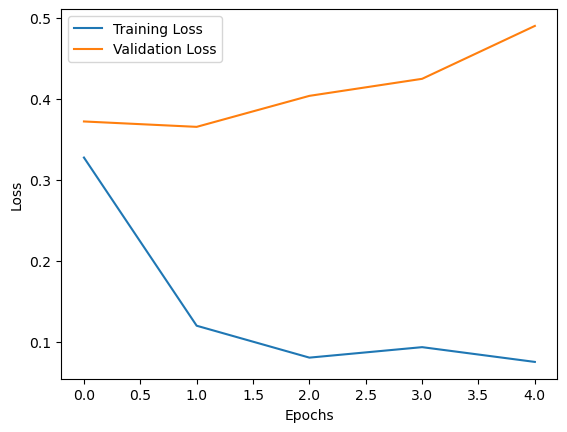

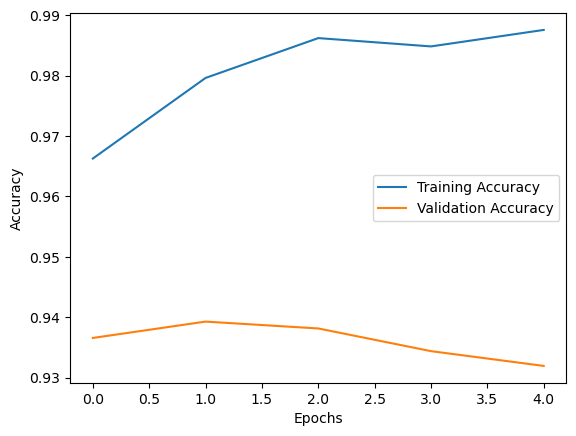

In [89]:
plot_loss_acc(history)

## loading and predicting model

In [70]:
loaded_merger=tf.keras.models.load_model("merger_model")

In [71]:
metrics=loaded_merger.evaluate([test_txt_ft,test_ft],test_labels)
print(f" Accuracy : {metrics[1]*100} \n Loss : {metrics[0]}")

448/448 [==============================] - 14s 31ms/step - loss: 0.3431 - accuracy: 0.9430
 Accuracy : 94.29689645767212 
 Loss : 0.343141108751297
